In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten,Dense
import pathlib

In [3]:
data_dir = pathlib.Path("dataset/train")

In [4]:
image_count = len(list(data_dir.glob('abw/*.jpg')))
print(image_count)

1695


In [5]:
image_count = len(list(data_dir.glob('pbw/*.jpg')))
print(image_count)

4946


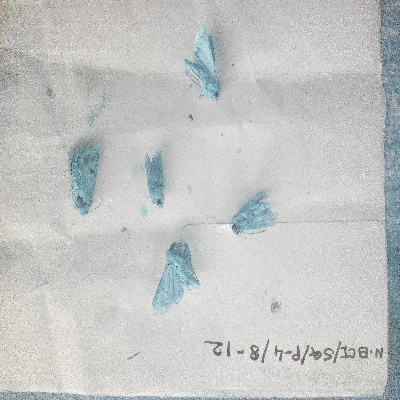

In [6]:
abw = list(data_dir.glob('abw/*'))
PIL.Image.open(str(abw[0]))

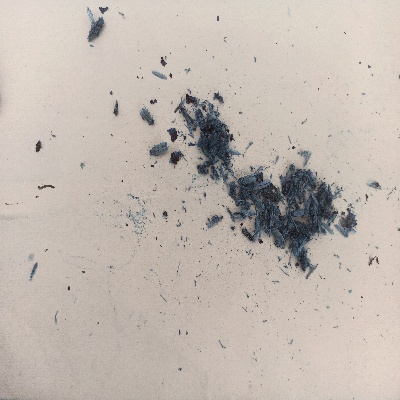

In [7]:
pbw = list(data_dir.glob('pbw/*'))
PIL.Image.open(str(pbw[0]))

In [7]:
batch_size = 10
img_height = 200
img_width = 200

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6642 files belonging to 2 classes.
Using 5314 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6642 files belonging to 2 classes.
Using 1328 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['abw', 'pbw']


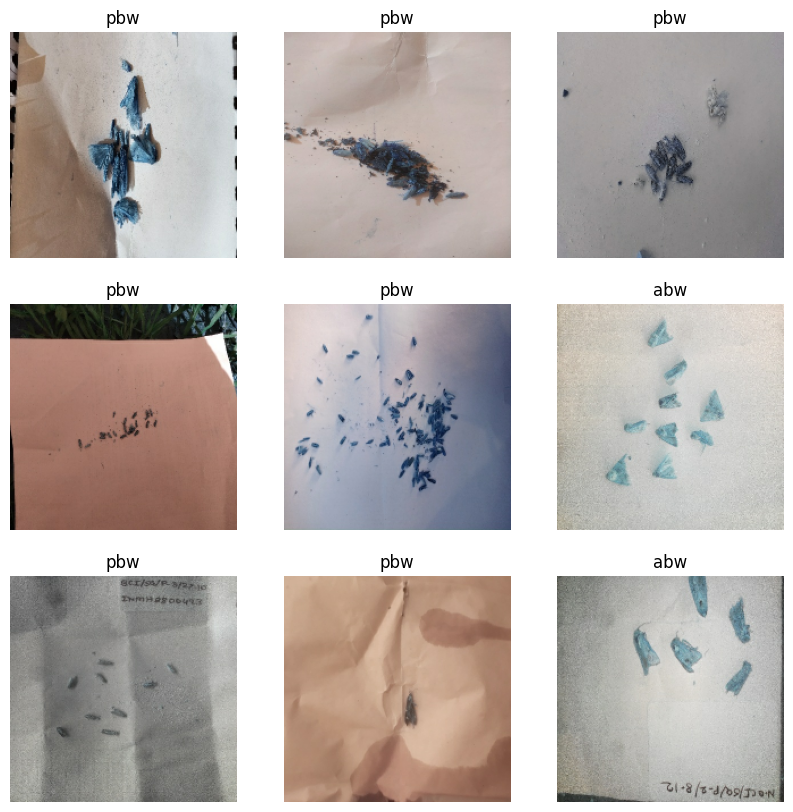

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
#AUTOTUNE = tf.data.AUTOTUNE
buffer_size=100

train_ds = train_ds.cache().shuffle(buffer_size).prefetch(buffer_size=buffer_size)
val_ds = val_ds.cache().shuffle(buffer_size).prefetch(buffer_size=buffer_size)
#print(AUTOTUNE)

# scalling

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
train_normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.09901962 0.7411765


In [15]:
val_normalized_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(val_normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.04803922 0.87352943


# Model building

## mode1 1v1

In [16]:
num_classes = 2

In [17]:
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(200,200,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=True

In [18]:
num_classes = 2

model = Sequential()
  
model.add(pretrained_model)
# model.add(Conv2D(64,(3,2),activation='relu'))
# model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes,activation='softmax'))


In [19]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 23,850,242
Trainable params: 23,797,122
Non-trainable params: 53,120
_________________________________________________________________


In [21]:
epochs=3
history = model.fit(
  train_normalized_ds,
  validation_data=val_normalized_ds,
  epochs=epochs
)

Epoch 1/3
532/532 [==============================] - 486s 894ms/step - loss: 0.5386 - accuracy: 0.7943 - val_loss: 10.8729 - val_accuracy: 0.7598
Epoch 2/3
532/532 [==============================] - 476s 895ms/step - loss: 0.3509 - accuracy: 0.8700 - val_loss: 5.1379 - val_accuracy: 0.4970
Epoch 3/3
532/532 [==============================] - 473s 890ms/step - loss: 0.3254 - accuracy: 0.8784 - val_loss: 0.3440 - val_accuracy: 0.9006


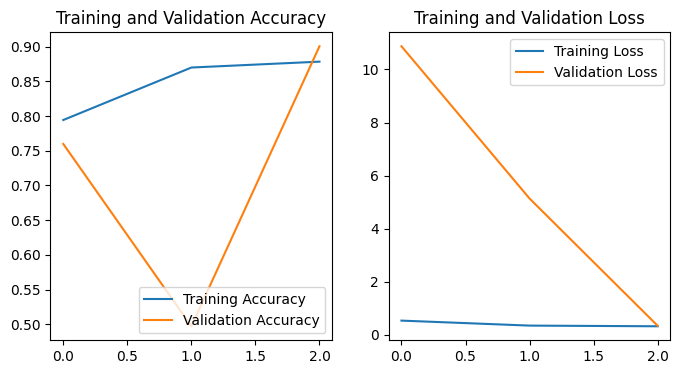

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3,3), activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(16, (3,3), activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(32,  (3,3), activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(64,  (3,3), activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [32]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 16)        2320      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 32)       

In [34]:
epochs=7
history = model.fit(
  train_normalized_ds,
  validation_data=val_normalized_ds,
  epochs=epochs
)

Epoch 1/7
167/167 [==============================] - 35s 202ms/step - loss: 0.5819 - accuracy: 0.7411 - val_loss: 0.5521 - val_accuracy: 0.7590
Epoch 2/7
167/167 [==============================] - 33s 195ms/step - loss: 0.5746 - accuracy: 0.7412 - val_loss: 0.5527 - val_accuracy: 0.7590
Epoch 3/7
167/167 [==============================] - 33s 195ms/step - loss: 0.5754 - accuracy: 0.7412 - val_loss: 0.5540 - val_accuracy: 0.7590
Epoch 4/7
167/167 [==============================] - 32s 194ms/step - loss: 0.5761 - accuracy: 0.7412 - val_loss: 0.5631 - val_accuracy: 0.7590
Epoch 5/7
167/167 [==============================] - 32s 195ms/step - loss: 0.5739 - accuracy: 0.7412 - val_loss: 0.5531 - val_accuracy: 0.7590
Epoch 6/7
167/167 [==============================] - 33s 195ms/step - loss: 0.5750 - accuracy: 0.7412 - val_loss: 0.5558 - val_accuracy: 0.7590
Epoch 7/7
167/167 [==============================] - 33s 195ms/step - loss: 0.5745 - accuracy: 0.7412 - val_loss: 0.5541 - val_accuracy:

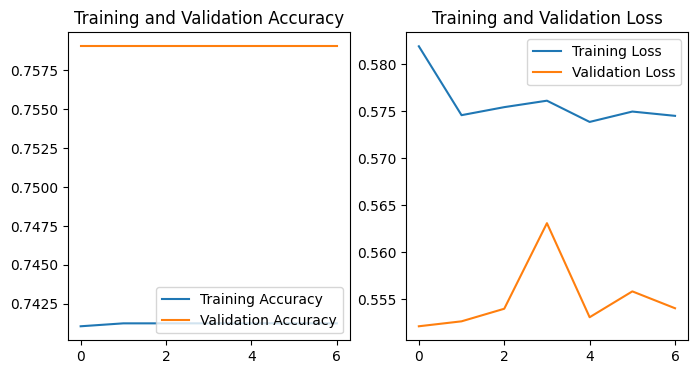

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64,  (5,5), activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(64,  (5,5), activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [18]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 196, 196, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 94, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 141376)            0

In [20]:
epochs=3
history = model.fit(
  train_normalized_ds,
  validation_data=val_normalized_ds,
  epochs=epochs
)

Epoch 1/3
167/167 [==============================] - 170s 976ms/step - loss: 0.5819 - accuracy: 0.7386 - val_loss: 0.5576 - val_accuracy: 0.7590
Epoch 2/3
167/167 [==============================] - 160s 958ms/step - loss: 0.5740 - accuracy: 0.7412 - val_loss: 0.5544 - val_accuracy: 0.7590
Epoch 3/3
167/167 [==============================] - 159s 954ms/step - loss: 0.5749 - accuracy: 0.7412 - val_loss: 0.5525 - val_accuracy: 0.7590


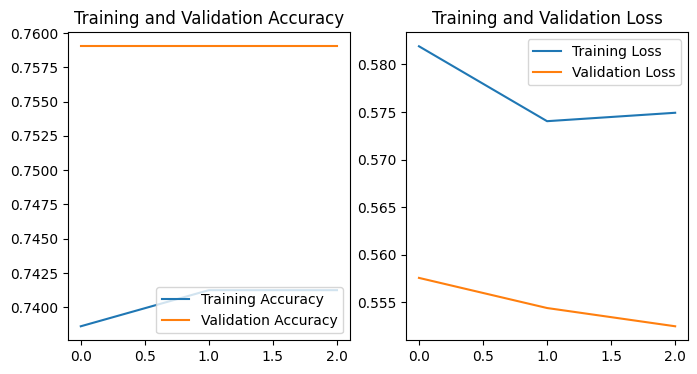

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()